In [1]:
import pandas as pd
from sys import path
import pandas as pd
from glob import glob
from sys import path
from tqdm.auto import tqdm

path.append("../")

from src.utils.plot import plot_categorical_distribution

from src.utils.plot import plot_categorical_distribution
from src.utils.data_preparation import (
    apply_filter,
    decompose_signal,
    segment_eda_data,
    process_empatica_data
)

questionnaire_data_path: str = (
    "/Users/leonardoalchieri/Datasets/SEED1/collected_questionnaires.xlsx"
)
lecture_info_path: str = "/Users/leonardoalchieri/Datasets/SEED1/lectures.xlsx"
eda_data_path: str = "/Users/leonardoalchieri/Datasets/LinoData/SEED/Data"

# Engagement Label Preparation

In [2]:
questionnaire_data = pd.read_excel(questionnaire_data_path, skiprows=16)
lecture_info = pd.read_excel(lecture_info_path)

In [3]:
# with filter by type "Lecture" since we are interested in lectures only, for get engagement
questionnaire_data = questionnaire_data[questionnaire_data["TYPE"] == "Lecture"]

In [4]:
def transform_likert_scale(value: str) -> int:
    likert_mapping = {
        "Strongly Disagree": 1,
        "Disagree": 2,
        "Neutral": 3,
        "Agree": 4,
        "Strongly Agree": 5
    }
    if value not in likert_mapping:
        return None
    return likert_mapping[value]

def get_engagement_score(data: pd.DataFrame) -> pd.DataFrame:
    data['ANSWER_SCORE'] = data['ANSWER'].apply(transform_likert_scale)

    reverse_mask = data['QUESTION'] == "I didn't feel very accomplished in this lecture."
    data.loc[reverse_mask, 'ANSWER_SCORE'] = 6 - data.loc[reverse_mask, 'ANSWER_SCORE']
    
    return data['ANSWER_SCORE'].mean()


engagement_scores = questionnaire_data.groupby(
    ["USERNAME", "EMPATICA_ID", "COURSE", "DATE", "MOMENT"]
).apply(get_engagement_score).reset_index(name='EMOTIONAL ENGAGEMENT')

/var/folders/r1/9l0x_94d47s2prkmk81tp0_r0000gn/T/ipykernel_79512/178363019.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(get_engagement_score).reset_index(name='EMOTIONAL ENGAGEMENT')


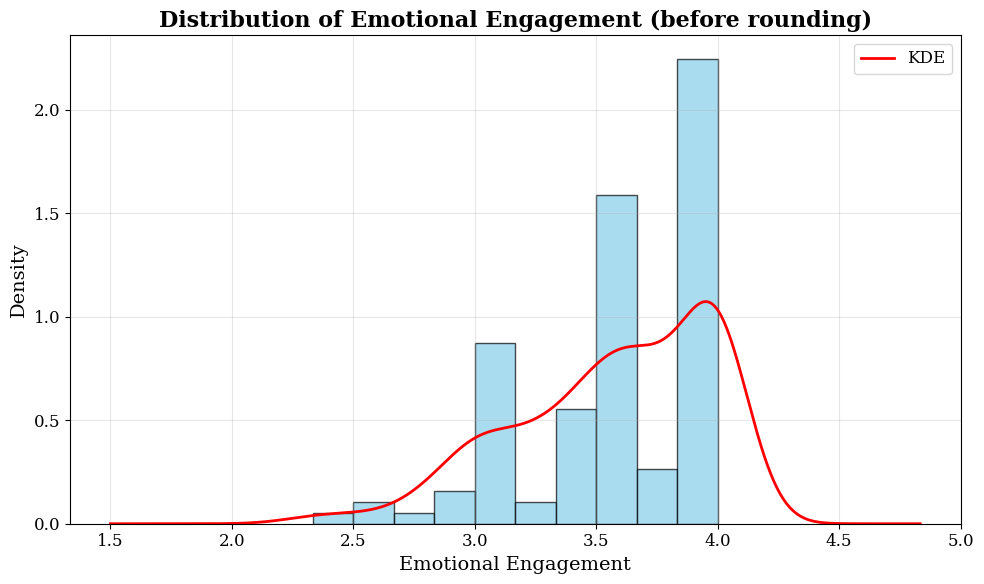

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set font styling (using mathtext instead of full LaTeX to avoid package issues)
plt.rcParams['text.usetex'] = False  # Disable LaTeX to avoid package issues
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern fonts for math

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram with KDE overlay
engagement_scores['EMOTIONAL ENGAGEMENT'].hist(bins=10, density=True, alpha=0.7, 
                                              color='skyblue', edgecolor='black', ax=ax)

# Add KDE curve
engagement_scores['EMOTIONAL ENGAGEMENT'].plot.kde(ax=ax, color='red', linewidth=2, 
                                                   label='KDE')

# Styling
ax.set_xlabel('Emotional Engagement', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_title('Distribution of Emotional Engagement (before rounding)', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
engagement_scores['EMOTIONAL ENGAGEMENT ROUNDED'] = engagement_scores['EMOTIONAL ENGAGEMENT'].round(0)

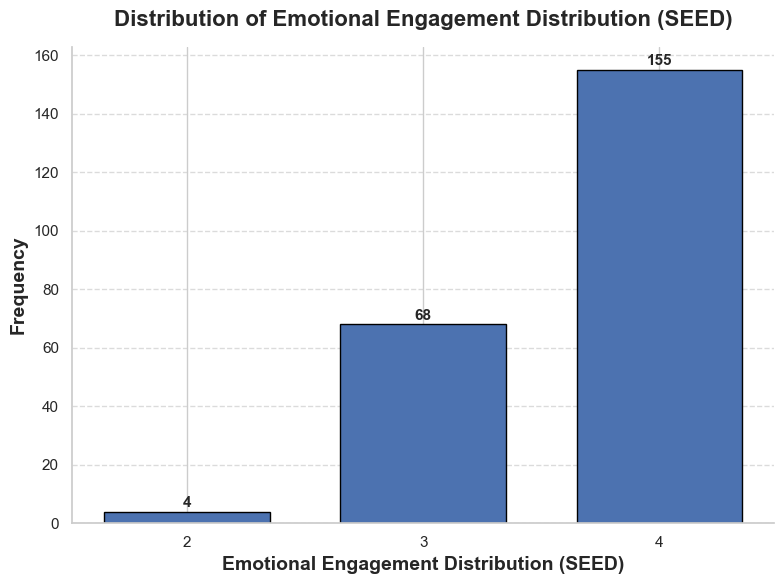

In [7]:
plot_categorical_distribution(
    labels=engagement_scores['EMOTIONAL ENGAGEMENT ROUNDED'].dropna().values.astype(int),
    label_name="Emotional Engagement Distribution (SEED)",
    use_latex=False
)

In [8]:
def split_lecture_times(df: pd.DataFrame) -> pd.DataFrame:
    splitted_df = pd.DataFrame(columns=['Lecture', 'Date', "Moment", "Start", "End"])
    if df['Break_end'] == 0:
        splitted_df = pd.DataFrame({
            'Lecture': df['Lecture'],
            'Date': df['Date'],
            "Moment": "After",
            "Start": df['Beginning'],
            "End": df['Break_beg']
        }, index=[0])
    else:
        splitted_df = pd.DataFrame({
            'Lecture': [df['Lecture'], df['Lecture']],
            'Date': [df['Date'], df['Date']],
            "Moment": ["Break", "After"],
            "Start": [df['Beginning'], df['Break_beg']],
            "End": [df['Break_end'], df['End']]
        })
    return splitted_df

# Collect all DataFrames and concatenate them
split_results = lecture_info.apply(split_lecture_times, axis=1)
lecture_info_corrected = pd.concat(split_results.tolist(), ignore_index=True)

In [9]:
engagement_scores["DATE_LECTURE"] = pd.to_datetime(engagement_scores["DATE"]).dt.strftime('%-d%b')
engagement_scores['DATE_LECTURE'] = engagement_scores['DATE_LECTURE'].apply(lambda x: f"{x}ch" if "Mar" in x else x)

In [10]:
engagement_scores["COURSE_BREV"] = engagement_scores["COURSE"].apply(
    lambda x: "".join([word[0] for word in x.split(" ") if word.lower() != "and"])
)

In [11]:
# def convert_moment(df: pd.DataFrame) -> pd.DataFrame:
#     if len(df) == 1:
#         display(df)
#         df['Moment'] = "After"
#     elif len(df) == 2:
#         df['Moment'].apply(lambda x: "Break" if x == "Part 1" else "After")
#     else:
#         raise ValueError("Unexpected number of moments in the DataFrame")
#     return df
# lecture_info.groupby(["Date", "Moment", "Course"]).apply(convert_moment)
# # lecture_info['Moment'] = lecture_info['Moment'].apply(lambda x: "Break" if x == "Part 1" else "After")

In [12]:
engagement_scores = engagement_scores.merge(
    lecture_info_corrected,
    left_on=["DATE_LECTURE", "MOMENT", "COURSE_BREV"],
    right_on=["Date", "Moment", "Lecture"],
    how="left"
)

In [14]:
engagement_scores.dropna(
    subset=["Lecture", "Date", "Moment", "Start", "End"], how='all'
)

,USERNAME,EMPATICA_ID,COURSE,DATE,MOMENT,EMOTIONAL ENGAGEMENT,EMOTIONAL ENGAGEMENT ROUNDED,DATE_LECTURE,COURSE_BREV,Lecture,Date,Moment,Start,End
0,S001,47,Linear Algebra,2017-02-22,After,3.500000,4.0,22Feb,LA,LA,22Feb,After,2017-02-22 08:33:00,2017-02-22 09:16:00
2,S001,47,Linear Algebra,2017-02-27,After,4.000000,4.0,27Feb,LA,LA,27Feb,After,2017-02-27 09:19:00,2017-02-27 10:11:00
3,S001,47,Linear Algebra,2017-02-27,Break,4.000000,4.0,27Feb,LA,LA,27Feb,Break,2017-02-27 08:32:00,2017-02-27 09:33:00
4,S001,47,Linear Algebra,2017-03-06,After,3.166667,3.0,6March,LA,LA,6March,After,2017-03-06 09:16:00,2017-03-06 10:11:00
5,S001,47,Linear Algebra,2017-03-06,Break,3.000000,3.0,6March,LA,LA,6March,Break,2017-03-06 08:35:00,2017-03-06 09:34:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,S049,49,Software Architecture and Design,2017-03-07,Break,3.500000,4.0,7March,SAD,SAD,7March,Break,2017-03-07 13:35:00,2017-03-07 14:33:00
324,S050,50,Software Architecture and Design,2017-02-23,After,3.666667,4.0,23Feb,SAD,SAD,23Feb,After,2017-02-23 14:25:00,2017-02-23 15:25:00
325,S050,50,Software Architecture and Design,2017-02-23,Break,3.333333,3.0,23Feb,SAD,SAD,23Feb,Break,2017-02-23 13:36:00,2017-02-23 14:36:00
326,S050,50,Software Architecture and Design,2017-03-07,After,3.666667,4.0,7March,SAD,SAD,7March,After,2017-03-07 14:23:00,2017-03-07 15:22:00


# EDA data preparation

In [15]:
engagement_scores = engagement_scores.rename(
    {"start": "Start", "end": "End"},
    axis=1,
    inplace=False,
)
engagement_scores = engagement_scores.dropna()

In [16]:
engagement_scores["Presentation_Id"] = engagement_scores.apply(
    lambda x: f'{x["DATE_LECTURE"]}_{x["MOMENT"]}_{x["Lecture"]}', axis=1
)
# engagement_scores = engagement_scores.drop(columns=["Presentation"])

In [17]:
eda_datas = glob(f"{eda_data_path}/*/*/EDA-*.csv")
users: list[str] = list(set([val.split("/")[7] for val in eda_datas]))
eda_data = {
    tuple(file.split("/")[7:9]): pd.read_csv(file, header=None).values.reshape(-1)
    for file in eda_datas
}

In [18]:
import numpy as np

def split_data_into_sessions_seed(data: np.ndarray, session_data: pd.DataFrame) -> dict:
    """
    Splits the EDA data into sessions based on the session start and end times.
    """
    sessions = {}
    data: pd.DataFrame = process_empatica_data(data)
    for _, row in session_data.iterrows():
        presentation_id = row["Presentation_Id"]
        start_time = row["Start"]
        end_time = row["End"]
        session_key = presentation_id
        selected_data = data[
            (data["Timestamp"] >= start_time) & (data["Timestamp"] <= end_time)
        ]
        if not selected_data.empty:
            sessions[session_key] = selected_data
    return sessions

processed_dict = {}
current_user: str = ""
session_dict: dict[str, pd.DataFrame] = {}
for key, val in tqdm(eda_data.items()):
    user, session = key
    if user != current_user:
        session_dict = {}
    current_user = user
    session_dict.update(split_data_into_sessions_seed(val, engagement_scores))
    processed_dict[user] = session_dict

  0%|          | 0/121 [00:00<?, ?it/s]

In [19]:
engagement_scores = engagement_scores.rename(
    {
        "Presentation_Id": "Presentation",
        "EMOTIONAL ENGAGEMENT": "Engagement",
        "USERNAME": "Audience",
    },
    axis=1,
)

In [20]:
# adding labels to the data

assert (
    len(engagement_scores)
    == engagement_scores[["Audience", "Presentation", "Lecture"]]
    .apply(lambda x: f"{x['Audience']}_{x['Presentation']}_{x['Lecture']}", axis=1)
    .nunique()
)

In [23]:
for _, (user, session) in engagement_scores[["Audience", "Presentation"]].iterrows():
    engagement = engagement_scores[
        (engagement_scores["Audience"] == user)
        & (engagement_scores["Presentation"] == session)
    ][["Engagement"]].values[0]
    if session not in processed_dict[user].keys():
        UserWarning(
            f"Session {session} not found for user {user}. Skipping."
        )
        print(f"Session {session} not found for user {user}. Skipping.")
        # del processed_dict[user][session]
        continue
    processed_dict[user][session].attrs["audience_survey"] = {
        "engagement": engagement,
    }

Session 3March_After_PF2 not found for user S001. Skipping.
Session 3March_Break_PF2 not found for user S001. Skipping.
Session 22Feb_After_LA not found for user S003. Skipping.
Session 22Feb_After_PF2 not found for user S003. Skipping.
Session 22Feb_Break_PF2 not found for user S003. Skipping.
Session 27Feb_After_LA not found for user S004. Skipping.
Session 27Feb_Break_LA not found for user S004. Skipping.
Session 27Feb_After_PF2 not found for user S004. Skipping.
Session 27Feb_Break_PF2 not found for user S004. Skipping.
Session 27Feb_Break_PF2 not found for user S011. Skipping.
Session 10March_After_PF2 not found for user S012. Skipping.
Session 10March_Break_PF2 not found for user S012. Skipping.


In [24]:
engagement_scores[engagement_scores['Presentation'] == "2March_After"]

,Audience,EMPATICA_ID,COURSE,DATE,MOMENT,Engagement,EMOTIONAL ENGAGEMENT ROUNDED,DATE_LECTURE,COURSE_BREV,Lecture,Date,Moment,Start,End,Presentation


In [27]:
processed_dict = {
    user: {
        session: processed_dict[user][session]
        for session in processed_dict[user].keys()
        if "audience_survey" in processed_dict[user][session].attrs
    }
    for user in processed_dict.keys()
}

In [28]:
cutoff_frequency = 0.4  # should not be changed, used like this by Elena Di Lascio
butterworth_order = 1  # should not be changed, used like this by Elena Di Lascio


filtered_data = {
    user: {
        session: apply_filter(
            data=data,
            cutoff_frequency=cutoff_frequency,
            butterworth_order=butterworth_order,
        )
        for session, data in user_dict.items()
    }
    for user, user_dict in processed_dict.items()
}

In [29]:
decomposed_data = {
    user: {
        session: decompose_signal(
            data=data,
        )
        for session, data in user_dict.items()
    }
    for user, user_dict in tqdm(filtered_data.items())
}

  0%|          | 0/31 [00:00<?, ?it/s]

     pcost       dcost       gap    pres   dres
 0: -2.0677e+02 -1.8151e+02  1e+03  4e+01  1e+00
 1: -2.2485e+02 -3.9183e+02  2e+02  6e+00  2e-01
 2: -2.3762e+02 -3.1760e+02  8e+01  2e+00  7e-02
 3: -2.4360e+02 -2.7614e+02  3e+01  6e-01  2e-02
 4: -2.4502e+02 -2.5473e+02  1e+01  1e-01  5e-03
 5: -2.4530e+02 -2.4842e+02  3e+00  3e-02  1e-03
 6: -2.4567e+02 -2.4620e+02  5e-01  3e-03  1e-04
 7: -2.4575e+02 -2.4590e+02  2e-01  8e-04  3e-05
 8: -2.4578e+02 -2.4580e+02  3e-02  8e-06  3e-07
 9: -2.4578e+02 -2.4579e+02  4e-03  1e-06  3e-08
10: -2.4578e+02 -2.4579e+02  6e-04  1e-07  4e-09
11: -2.4579e+02 -2.4579e+02  1e-04  2e-08  6e-10
12: -2.4579e+02 -2.4579e+02  2e-05  3e-09  9e-11
13: -2.4579e+02 -2.4579e+02  3e-06  4e-10  1e-11
14: -2.4579e+02 -2.4579e+02  6e-07  7e-11  2e-12
15: -2.4579e+02 -2.4579e+02  3e-08  2e-12  8e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5396e+02 -2.8253e+02  3e+03  6e+01  1e+00
 1: -4.0348e+02 -9.3465e+02  7e+02  1e+01  2e-0

In [30]:
segmented_data = []
engagement_labels = []
groups = []
for user, user_dict in decomposed_data.items():
    for session, session_data in user_dict.items():
        (
            current_segments,
            current_engagements,
            segmented_groups,
        ) = segment_eda_data(session_data, user, segment_length=10, keys_to_get=['engagement'])
        segmented_data.extend(current_segments)
        engagement_labels.extend(current_engagements)
        groups.extend(segmented_groups)

In [41]:
segmented_data = np.stack(segmented_data, axis=0)
engagement_labels = np.stack(engagement_labels, axis=0)
engagement_labels_binary_1 = (engagement_labels  >= 4).astype(int)
engagement_labels_binary_2 = (engagement_labels  > np.median(engagement_labels)).astype(int)
engagement_labels_binary_3 = (engagement_labels  >= 3.5).astype(int)

In [35]:
segmented_data.shape

(3869, 40, 3)

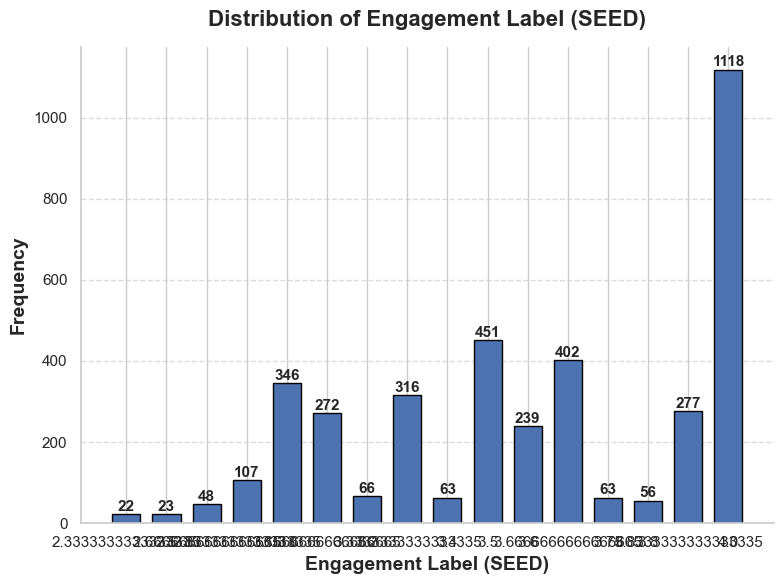

In [33]:
plot_categorical_distribution(
    engagement_labels,
    label_name="Engagement Label (SEED)",
    use_latex=False
)

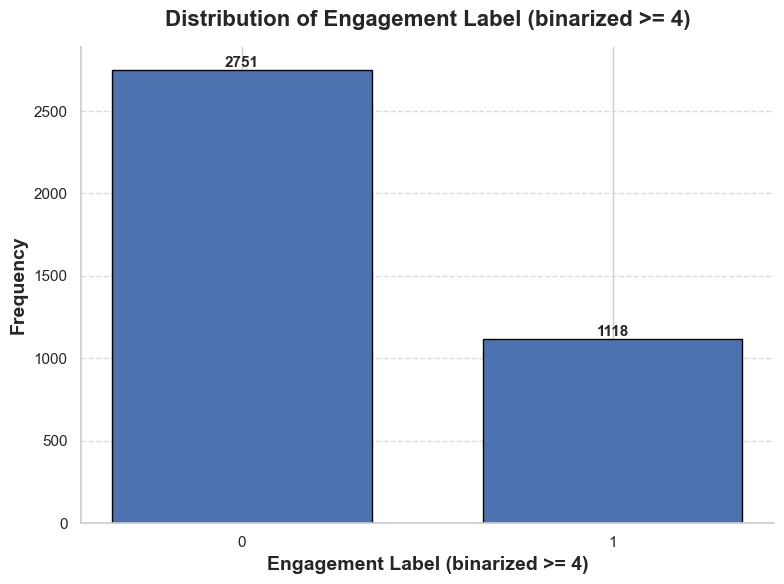

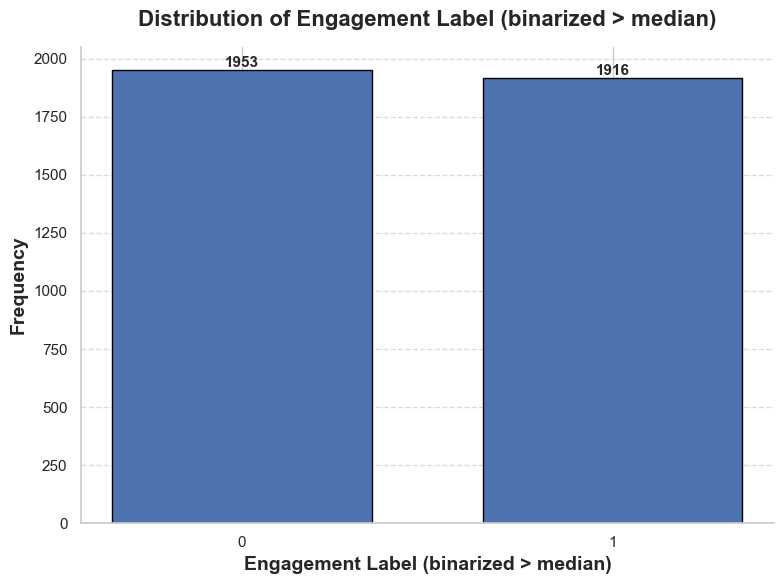

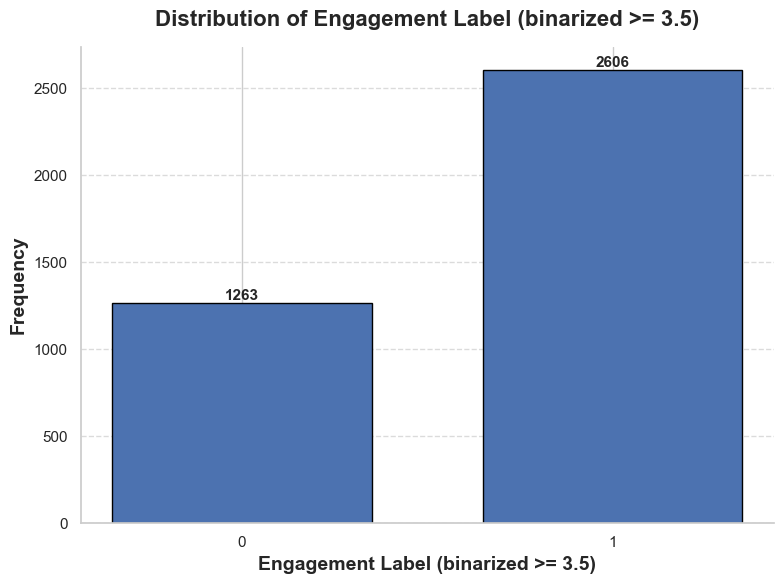

In [43]:
plot_categorical_distribution(
    engagement_labels_binary_1,
    label_name="Engagement Label (binarized >= 4)",
    use_latex=False,
)
plot_categorical_distribution(
    engagement_labels_binary_2,
    label_name="Engagement Label (binarized > median)",
    use_latex=False,
)
plot_categorical_distribution(
    engagement_labels_binary_3,
    label_name="Engagement Label (binarized >= 3.5)",
    use_latex=False,
)

In [44]:
np.savez("../data.nosync/seed/data_engagement_10sec_4thresh.npz",
         values=segmented_data,
         labels=engagement_labels_binary_1,
         groups=groups,
         name='SEED (engamgent)')

np.savez("../data.nosync/seed/data_engagement_10sec_medianthresh.npz",
         values=segmented_data,
         labels=engagement_labels_binary_2,
         groups=groups,
         name='SEED (engamgent)')

np.savez("../data.nosync/seed/data_engagement_10sec_35thresh.npz",
         values=segmented_data,
         labels=engagement_labels_binary_3,
         groups=groups,
         name='SEED (engamgent)')